<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">RNN, LSTM and GRUs</h2>

using Tensor Flow and Keras

Based on this [post](https://blog.quantinsti.com/rnn-lstm-gru-trading/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com)

Let’s start off by importing the classes and functions we intend to use to train our model.

In [32]:
import numpy as np
import sys
import re
import pandas as pd
import math
import time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [33]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In this section we will develop a simple LSTM network to learn sequences of characters from Alice in Wonderland. In the next section we will use this model to generate new sequences of characters.

Next, we need to load the ASCII text for the book into memory and convert all of the characters to lowercase to reduce the vocabulary that the network must learn.

In [34]:
# load ascii text and covert to lowercase
filename = "../../../data/wonderland.txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()

In [35]:
raw_text.find('happy summer days.\n\n')

144987

In [36]:
raw_text = raw_text[:145000]

Cleaning the text:

In [37]:
raw_text = raw_text[raw_text.find('\n\n\n\n'):]
raw_text = re.sub(r'[\n ]+',' ', raw_text)

import string
for char in string.punctuation:
    raw_text = raw_text.replace(char, ' ')

raw_text = raw_text.replace('  ', ' ')
raw_text = raw_text.replace('  ', ' ')

Now that the book is loaded, we must prepare the data for modeling by the neural network. We cannot model the characters directly, instead we must convert the characters to integers.

We can do this easily by first creating a set of all of the distinct characters in the book, then creating a map of each character to a unique integer.

In [38]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

For example, the list of unique sorted lowercase characters in the book is as follows:

In [39]:
char_to_int

{' ': 0,
 '0': 1,
 '3': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

You can see that there may be some characters that we could remove to further clean up the dataset that will reduce the vocabulary and may improve the modeling process.

Now that the book has been loaded and the mapping prepared, we can summarize the dataset.

In [40]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  135172
Total Vocab:  29


We can see that the book has just under 150,000 characters and that when converted to lowercase that there are only 37 distinct characters in the vocabulary for the network to learn. Much more than the 26 in the alphabet.

We now need to define the training data for the network. There is a lot of flexibility in how you choose to break up the text and expose it to the network during training.

In this tutorial we will split the book text up into subsequences with a fixed length of 100 characters, an arbitrary length. We could just as easily split the data up by sentences and pad the shorter sequences and truncate the longer ones.

Each training pattern of the network is comprised of 100 time steps of one character (X) followed by one character output (y). When creating these sequences, we slide this window along the whole book one character at a time, allowing each character a chance to be learned from the 100 characters that preceded it (except the first 100 characters of course).

For example, if the sequence length is 5 (for simplicity) then the first two training patterns would be as follows:  

CHAPT -> E
HAPTE -> R

As we split up the book into these sequences, we convert the characters to integers using our lookup table we prepared earlier.  

In [41]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  135072


Running the code to this point shows us that when we split up the dataset into training data for the network to learn that we have just under 150,000 training pattens. This makes sense as excluding the first 100 characters, we have one training pattern to predict each of the remaining characters.  

Now that we have prepared our training data we need to transform it so that it is suitable for use with Keras.

First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network.

Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default.

Finally, we need to convert the output patterns (single characters converted to integers) into a one hot encoding. This is so that we can configure the network to predict the probability of each of the 47 different characters in the vocabulary (an easier representation) rather than trying to force it to predict precisely the next character. Each y value is converted into a sparse vector with a length of 47, full of zeros except with a 1 in the column for the letter (integer) that the pattern represents.

We can implement these steps as below.  

In [42]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = tf.keras.utils.to_categorical(dataY)

We can now define our LSTM model. Here we define a single hidden LSTM layer with 256 memory units. The network uses dropout with a probability of 20. The output layer is a Dense layer using the softmax activation function to output a probability prediction for each of the 47 characters between 0 and 1.

The problem is really a single character classification problem with 47 classes and as such is defined as optimizing the log loss (cross entropy), here using the ADAM optimization algorithm for speed.

In [43]:
# define the LSTM model

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

There is no test dataset. We are modeling the entire training dataset to learn the probability of each character in a sequence.

We are not interested in the most accurate (classification accuracy) model of the training dataset. This would be a model that predicts each character in the training dataset perfectly. Instead we are interested in a generalization of the dataset that minimizes the chosen loss function. We are seeking a balance between generalization and overfitting but short of memorization.

The network is slow to train (about 300 seconds per epoch on an Nvidia K520 GPU). Because of the slowness and because of our optimization requirements, we will use model checkpointing to record all of the network weights to file each time an improvement in loss is observed at the end of the epoch. We will use the best set of weights (lowest loss) to instantiate our generative model in the next section.

In [44]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

We can now fit our model to the data. Here we use a modest number of 20/30 epochs and a large batch size of 32/64/128 patterns.

In [45]:
t0 = time.time()

history = model.fit(X, y, 
                    epochs=10, 
                    batch_size=32, 
                    callbacks=callbacks_list, 
                    verbose=1)

print(f"training took {(time.time() - t0)/60} minutes")

Epoch 1/10
4221/4221 [==============================] - ETA: 0s - loss: 2.6378
Epoch 1: loss improved from inf to 2.63780, saving model to weights-improvement-01-2.6378.hdf5
4221/4221 [==============================] - 27s 6ms/step - loss: 2.6378
Epoch 2/10
4213/4221 [============================>.] - ETA: 0s - loss: 2.4218
Epoch 2: loss improved from 2.63780 to 2.42127, saving model to weights-improvement-02-2.4213.hdf5
4221/4221 [==============================] - 25s 6ms/step - loss: 2.4213
Epoch 3/10
4219/4221 [============================>.] - ETA: 0s - loss: 2.2817
Epoch 3: loss improved from 2.42127 to 2.28162, saving model to weights-improvement-03-2.2816.hdf5
4221/4221 [==============================] - 25s 6ms/step - loss: 2.2816
Epoch 4/10
4216/4221 [============================>.] - ETA: 0s - loss: 2.1703
Epoch 4: loss improved from 2.28162 to 2.17044, saving model to weights-improvement-04-2.1704.hdf5
4221/4221 [==============================] - 25s 6ms/step - loss: 2.1704


In [46]:
# list all data in history
print(history.history.keys())

dict_keys(['loss'])


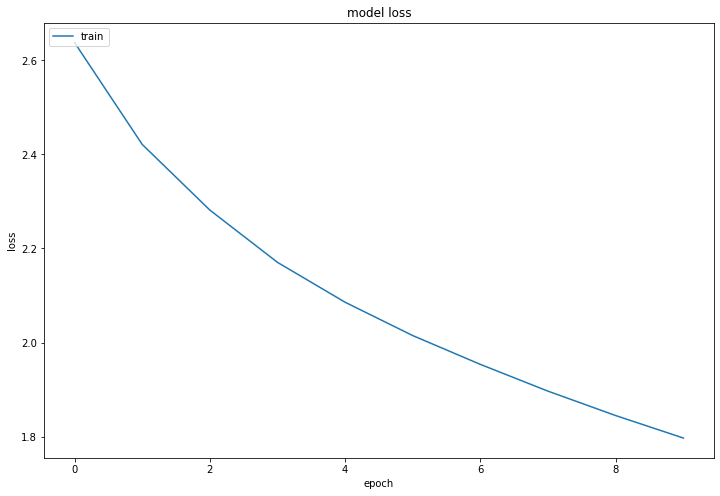

In [47]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The network loss decreased almost every epoch and I expect the network could benefit from training for many more epochs.

In the next section we will look at using this model to generate new text sequences.

You will see different results because of the stochastic nature of the model, and because it is hard to fix the random seed for LSTM models to get 100% reproducible results. This is not a concern for this generative model.

After running the example, you should have a number of weight checkpoint files in the local directory.

You can delete them all except the one with the smallest loss value.

In [48]:
filenames = [x for x in os.listdir() if x.endswith('hdf5')]

loss = 9.9999
chosen = ''
for filename in filenames:
    pattern = re.search("([0-9]{2})(\-)([0-9]{1}\.{1}[0-9]{4})(\.)",filename)
    if pattern:
        newloss = float(pattern.group(3).strip('.')) 
    if newloss < loss:
        loss = newloss
        chosen = filename

Cleaning the suboptimal weight files

In [49]:
filenames.remove(chosen)
for filename in filenames:
    os.remove(filename)

### Generating Text with an LSTM Network

Generating text using the trained LSTM network is relatively straightforward.

Firstly, we load the data and define the network in exactly the same way, except the network weights are loaded from a checkpoint file and the network does not need to be trained.

In [50]:
# load the network weights
model.load_weights(chosen)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Also, when preparing the mapping of unique characters to integers, we must also create a reverse mapping that we can use to convert the integers back to characters so that we can understand the predictions.

In [51]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

Finally, we need to actually make predictions.

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as we want to predict new characters (e.g. a sequence of 1,000 characters in length).

We can pick a random input pattern as our seed sequence, then print generated characters as we generate them.

Running this example first outputs the selected random seed, then each character as it is generated.

For example, below are the results from one run of this text generator. The random seed was:

In [52]:
#pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" ain so that altogether for the first minute or two it was as much as she could do to hold it as soon "
 alice she had been to the bage wou d date said the ming and the horpe and the harter was soie and the march hare said to herself a soting to said the katter a tore and the said the karter and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee and alice was soiee 

We can note some observations about the generated text.  
+ It generally conforms to the line format observed in the original text of less than 80 characters before a new line.
+ The characters are separated into word-like groups and most groups are actual English words (e.g. “the”, “little” and “was”), but many do not (e.g. “lott”, “tiie” and “taede”).
+ Some of the words in sequence make sense(e.g. “and the white rabbit“), but many do not (e.g. “wese tilel“).

The fact that this character based model of the book produces output like this is very impressive. It gives you a sense of the learning capabilities of LSTM networks.

The results are not perfect. In the next section we look at improving the quality of results by developing a much larger LSTM network.

### Larger LSTM Recurrent Neural Network

We got results, but not excellent results in the previous section. Now, we can try to improve the quality of the generated text by creating a much larger network.

We will keep the number of memory units the same at 256, but add a second layer.

In [53]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

We will also change the filename of the checkpointed weights so that we can tell the difference between weights for this network and the previous (by appending the word “bigger” in the filename).

In [54]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"

Finally, we will increase the number of training epochs from 20 to 50 and use batch size 32/64 to give the network more of an opportunity to be updated and learn.

In [55]:
t0 = time.time()

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')
callbacks_list = [checkpoint]
# fit the model
history = model.fit(X, y, 
                    epochs=10, 
                    batch_size=32, 
                    callbacks=callbacks_list)

print(f"training took {(time.time() - t0)/60} minutes")

Epoch 1/10
4218/4221 [============================>.] - ETA: 0s - loss: 2.4296
Epoch 1: loss improved from inf to 2.42949, saving model to weights-improvement-01-2.4295-bigger.hdf5
4221/4221 [==============================] - 56s 13ms/step - loss: 2.4295
Epoch 2/10
4221/4221 [==============================] - ETA: 0s - loss: 2.0022
Epoch 2: loss improved from 2.42949 to 2.00224, saving model to weights-improvement-02-2.0022-bigger.hdf5
4221/4221 [==============================] - 53s 13ms/step - loss: 2.0022
Epoch 3/10
4219/4221 [============================>.] - ETA: 0s - loss: 1.8282
Epoch 3: loss improved from 2.00224 to 1.82814, saving model to weights-improvement-03-1.8281-bigger.hdf5
4221/4221 [==============================] - 53s 13ms/step - loss: 1.8281
Epoch 4/10
4218/4221 [============================>.] - ETA: 0s - loss: 1.7218
Epoch 4: loss improved from 1.82814 to 1.72185, saving model to weights-improvement-04-1.7219-bigger.hdf5
4221/4221 [==============================]

In [56]:
# list all data in history
print(history.history.keys())

dict_keys(['loss'])


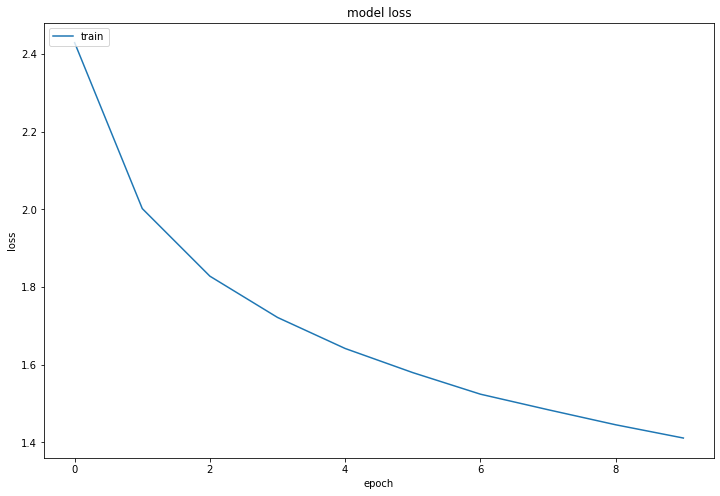

In [57]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
filenames = [x for x in os.listdir() if x.endswith('bigger.hdf5')]

loss = 9.9999
chosen = ''
for filename in filenames:
    pattern = re.search("([0-9]{2})(\-)([0-9]{1}\.{1}[0-9]{4})(\-bigger)",filename)
    if pattern:
        newloss = float(pattern.group(3).strip('.')) 
    if newloss < loss:
        loss = newloss
        chosen = filename

Cleaning the suboptimal weight files

In [59]:
filenames.remove(chosen)
for filename in filenames:
    os.remove(filename)

In [60]:
# load the network weights
model.load_weights(chosen)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [61]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

One example of running this text generation script produces the output below.

The randomly chosen seed text was:

In [62]:
#pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
"  at last said alice in a tone of delight which changed into alarm in another moment when she found t "
he dormouse she was to the court and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mock turtle senling and the sueen s heard the mo

We can see that generally there are fewer spelling mistakes and the text looks more realistic, but is still quite nonsensical.

For example the same phrases get repeated again and again. Quotes are opened but not closed.

These are better results but there is still a lot of room for improvement.

### 10 Extension Ideas to Improve the Model

Below are 10 ideas that may further improve the model that you could experiment with are:

  + Predict fewer than 1,000 characters as output for a given seed.
  + Remove all punctuation from the source text, and therefore from the models’ vocabulary.
  + Try a one hot encoded for the input sequences.
  + Train the model on padded sentences rather than random sequences of characters.
  + Increase the number of training epochs to 100 or many hundreds.
  + Add dropout to the visible input layer and consider tuning the dropout percentage.
  + Tune the batch size, try a batch size of 1 as a (very slow) baseline and larger sizes from there.
  + Add more memory units to the layers and/or more layers.
  + Experiment with scale factors (temperature) when interpreting the prediction probabilities.
  + Change the LSTM layers to be “stateful” to maintain state across batches.


#### Resources

This character text model is a popular way for generating text using recurrent neural networks.

Below are some more resources and tutorials on the topic if you are interested in going deeper. Perhaps the most popular is the tutorial by Andrej Karpathy titled “The Unreasonable Effectiveness of Recurrent Neural Networks“.

+ [Generating Text with Recurrent Neural Networks](http://www.cs.utoronto.ca/~ilya/pubs/2011/LANG-RNN.pdf)
+ [Keras code example of LSTM for text generation](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py)
+ [Lasagne code example of LSTM for text generation](https://github.com/Lasagne/Recipes/blob/master/examples/lstm_text_generation.py)  
+ [MXNet tutorial for using an LSTM for text generation](http://mxnetjl.readthedocs.io/en/latest/tutorial/char-lstm.html)
+ [Auto-Generating Clickbait With Recurrent Neural Networks](https://larseidnes.com/2015/10/13/auto-generating-clickbait-with-recurrent-neural-networks/)

#### Summary

In this notebook you discovered how you can develop an LSTM recurrent neural network for text generation in Python with the Keras deep learning library.

+ Where to download the ASCII text for classical books for free that you can use for training.
+ How to train an LSTM network on text sequences and how to use the trained network to generate new sequences.
+ How to develop stacked LSTM networks and lift the performance of the model.